In [1]:
# Add lxmls path to root.
import sys
import os
base_path = os.path.dirname(os.path.dirname(os.path.dirname(os.path.realpath(os.path.dirname('__file__')))))
sys.path.append(base_path)

In [2]:
# Other imports.
import sys
import lxmls.readers.simple_sequence as ssr
import lxmls.sequences.hmm as hmmc
import lxmls.readers.pos_corpus as pcc
import lxmls.sequences.confusion_matrix as cm

# Exercise 2.1
Load the simple sequence dataset. From the ipython command line create a simple sequence object and look at the training and test set.

In [3]:
simple = ssr.SimpleSequence()
print(simple.train)
print(simple.test)

[walk/rainy walk/sunny shop/sunny clean/sunny , walk/rainy walk/rainy shop/rainy clean/sunny , walk/sunny shop/sunny shop/sunny clean/sunny ]
[walk/rainy walk/sunny shop/sunny clean/sunny , clean/sunny walk/sunny tennis/sunny walk/sunny ]


In [4]:
for sequence in simple.train.seq_list:
    print(sequence)

walk/rainy walk/sunny shop/sunny clean/sunny 
walk/rainy walk/rainy shop/rainy clean/sunny 
walk/sunny shop/sunny shop/sunny clean/sunny 


In [5]:
for sequence in simple.train.seq_list:
    print(sequence.x)

[0, 0, 1, 2]
[0, 0, 1, 2]
[0, 1, 1, 2]


In [6]:
for sequence in simple.train.seq_list:
    print(sequence.y)

[0, 1, 1, 1]
[0, 0, 0, 1]
[1, 1, 1, 1]


# Exercise 2.2
The provided function train supervised from the hmm.py file implements the above parameter estimates.
Run this function given the simple dataset above and look at the estimated probabilities. Are they correct? You can also
check the variables ending in counts instead of probs to see the raw counts (for example, typing hmm.initial counts
will show you the raw counts of initial states). How are the counts related to the probabilities?

In [7]:
hmm = hmmc.HMM(simple.x_dict, simple.y_dict)
hmm.train_supervised(simple.train)

print("Initial Probabilities:")
print(hmm.initial_probs)

Initial Probabilities:
[0.66666667 0.33333333]


In [8]:
print("Transition Probabilities:")
print(hmm.transition_probs)

Transition Probabilities:
[[0.5   0.   ]
 [0.5   0.625]]


In [9]:
print("Final Probabilities:")
print(hmm.final_probs)

Final Probabilities:
[0.    0.375]


In [10]:
print("Emission Probabilities")
print(hmm.emission_probs)

Emission Probabilities
[[0.75  0.25 ]
 [0.25  0.375]
 [0.    0.375]
 [0.    0.   ]]


# Exercise 2.3 
Convince yourself that the score of a path in the trellis (summing over the scores above) is equivalent to the
log-probability $\log P(X = x, Y = y)$, as defined in Eq. 2.2. Use the given function compute scores on the first training
sequence and confirm that the values are correct. You should get the same values as presented below

In [11]:
initial_scores, transition_scores, final_scores, emission_scores = \
    hmm.compute_scores(simple.train.seq_list[0])
print(initial_scores)

[-0.40546511 -1.09861229]


/home/pedro/Sandbox/lxmls-toolkit/lxmls/sequences/hmm.py:194: RuntimeWarning: divide by zero encountered in log
  transition_scores[pos-1, :, :] = np.log(self.transition_probs)
/home/pedro/Sandbox/lxmls-toolkit/lxmls/sequences/hmm.py:192: RuntimeWarning: divide by zero encountered in log
  emission_scores[pos, :] = np.log(self.emission_probs[sequence.x[pos], :])
/home/pedro/Sandbox/lxmls-toolkit/lxmls/sequences/hmm.py:197: RuntimeWarning: divide by zero encountered in log
  final_scores = np.log(self.final_probs)


In [12]:
print(transition_scores)

[[[-0.69314718        -inf]
  [-0.69314718 -0.47000363]]

 [[-0.69314718        -inf]
  [-0.69314718 -0.47000363]]

 [[-0.69314718        -inf]
  [-0.69314718 -0.47000363]]]


In [13]:
print(final_scores)

[       -inf -0.98082925]


In [14]:
print(emission_scores)

[[-0.28768207 -1.38629436]
 [-0.28768207 -1.38629436]
 [-1.38629436 -0.98082925]
 [       -inf -0.98082925]]


# Exercise 2.4 
Look at the module ``sequences/log domain.py``. This module implements a function ``logsum pair(logx, logy)`` to add two numbers represented in the log-domain; it returns their sum also represented in the log-domain. The
function logsum(logv) sums all components of an array represented in the log-domain. This will be used later in our
decoding algorithms. To observe why this is important, type the following:

In [15]:
import numpy as np

a = np.random.rand(10)
print(np.log(sum(np.exp(a))))
print(np.log(sum(np.exp(10*a))))
print(np.log(sum(np.exp(100*a))))
print(np.log(sum(np.exp(1000*a))))

2.8467051967265222
9.796143990021935
95.18785291224812
inf


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


In [16]:
from lxmls.sequences.log_domain import logsum

print(logsum(a))
print(logsum(10*a))
print(logsum(100*a))
print(logsum(1000*a))

2.8467051967265222
9.796143990021935
95.18785291224812
951.8785289331881


# Exercise 2.5 
Run the provided forward-backward algorithm on the first train sequence. Observe that both the forward
and the backward passes give the same log-likelihood.

In [17]:
log_likelihood, forward = hmm.decoder.run_forward(initial_scores, transition_scores, final_scores, emission_scores)
print('Log-Likelihood = {}'.format(log_likelihood))

Log-Likelihood = -5.068232326005127


In [18]:
log_likelihood, backward = hmm.decoder.run_backward(initial_scores, transition_scores, final_scores, emission_scores)
print('Log-Likelihood = {}'.format(log_likelihood))

Log-Likelihood = -5.068232326005126


# Exercise 2.6 
Compute the node posteriors for the first training sequence (use the provided compute posteriors function), and look at the output. Note that the state posteriors are a proper probability distribution (the lines of the result
sum to 1)

In [19]:
initial_scores, transition_scores, final_scores, emission_scores = \
    hmm.compute_scores(simple.train.seq_list[0])
state_posteriors, _, _ = hmm.compute_posteriors(initial_scores,
                                                transition_scores,
                                                final_scores,
                                                emission_scores)
print(state_posteriors)

[[0.95738152 0.04261848]
 [0.75281282 0.24718718]
 [0.26184794 0.73815206]
 [0.         1.        ]]


/home/pedro/Sandbox/lxmls-toolkit/lxmls/sequences/hmm.py:194: RuntimeWarning: divide by zero encountered in log
  transition_scores[pos-1, :, :] = np.log(self.transition_probs)
/home/pedro/Sandbox/lxmls-toolkit/lxmls/sequences/hmm.py:192: RuntimeWarning: divide by zero encountered in log
  emission_scores[pos, :] = np.log(self.emission_probs[sequence.x[pos], :])
/home/pedro/Sandbox/lxmls-toolkit/lxmls/sequences/hmm.py:197: RuntimeWarning: divide by zero encountered in log
  final_scores = np.log(self.final_probs)


# Exercise 2.7 
Run the posterior decode on the first test sequence, and evaluate it.

In [20]:
y_pred = hmm.posterior_decode(simple.test.seq_list[0])
print("Prediction test 0: {}".format(y_pred))
print("Truth test 0: {}".format(simple.test.seq_list[0]))

Prediction test 0: walk/rainy walk/rainy shop/sunny clean/sunny 
Truth test 0: walk/rainy walk/sunny shop/sunny clean/sunny 


/home/pedro/Sandbox/lxmls-toolkit/lxmls/sequences/hmm.py:194: RuntimeWarning: divide by zero encountered in log
  transition_scores[pos-1, :, :] = np.log(self.transition_probs)
/home/pedro/Sandbox/lxmls-toolkit/lxmls/sequences/hmm.py:192: RuntimeWarning: divide by zero encountered in log
  emission_scores[pos, :] = np.log(self.emission_probs[sequence.x[pos], :])
/home/pedro/Sandbox/lxmls-toolkit/lxmls/sequences/hmm.py:197: RuntimeWarning: divide by zero encountered in log
  final_scores = np.log(self.final_probs)


Do the same for the second test sequence:

In [21]:
y_pred = hmm.posterior_decode(simple.test.seq_list[1])
print("Prediction test 1", y_pred)
print("Truth test 1", simple.test.seq_list[1])

Prediction test 1 clean/rainy walk/rainy tennis/rainy walk/rainy 
Truth test 1 clean/sunny walk/sunny tennis/sunny walk/sunny 


/home/pedro/Sandbox/lxmls-toolkit/lxmls/sequences/hmm.py:192: RuntimeWarning: divide by zero encountered in log
  emission_scores[pos, :] = np.log(self.emission_probs[sequence.x[pos], :])
/home/pedro/Sandbox/lxmls-toolkit/lxmls/sequences/hmm.py:194: RuntimeWarning: divide by zero encountered in log
  transition_scores[pos-1, :, :] = np.log(self.transition_probs)
/home/pedro/Sandbox/lxmls-toolkit/lxmls/sequences/hmm.py:197: RuntimeWarning: divide by zero encountered in log
  final_scores = np.log(self.final_probs)
/home/pedro/Sandbox/lxmls-toolkit/lxmls/sequences/sequence_classifier.py:80: RuntimeWarning: invalid value encountered in subtract
  state_posteriors[pos, :] -= log_likelihood
/home/pedro/Sandbox/lxmls-toolkit/lxmls/sequences/sequence_classifier.py:93: RuntimeWarning: invalid value encountered in double_scalars
  transition_posteriors[pos, state, prev_state] -= log_likelihood


What is wrong? Note the observations for the second test sequence: the observation tennis was never seen at
training time, so the probability for it will be zero (no matter what state). This will make all possible state sequences have
zero probability. As seen in the previous lecture, this is a problem with generative models, which can be corrected using
smoothing (among other options).

Change the train supervised method to add smoothing:

    def train_supervised(self,sequence_list, smoothing):
        

### Solution
````
def train_supervised(self, dataset, smoothing=0):
    """ Train an HMM from a list of sequences containing observations
    and the gold states. This is just counting and normalizing."""
    # Set all counts to zeros (optionally, smooth).
    self.clear_counts(smoothing)
    # Count occurrences of events.
    self.collect_counts_from_corpus(dataset)
    # Normalize to get probabilities.
    self.compute_parameters()
````
Mode detaials see class HMM in lxmls.sequences.hmm

In [22]:
hmm.train_supervised(simple.train, smoothing=0.1)

y_pred = hmm.posterior_decode(simple.test.seq_list[0])
print("Prediction test 0 with smoothing")
print(y_pred)
print("Truth test 0")
print(simple.test.seq_list[0])

Prediction test 0 with smoothing
walk/rainy walk/rainy shop/sunny clean/sunny 
Truth test 0
walk/rainy walk/sunny shop/sunny clean/sunny 


In [23]:
y_pred = hmm.posterior_decode(simple.test.seq_list[1])
print("Prediction test 1 with smoothing")
print(y_pred)
print("Truth test 1")
print(simple.test.seq_list[1])

Prediction test 1 with smoothing
clean/sunny walk/sunny tennis/sunny walk/sunny 
Truth test 1
clean/sunny walk/sunny tennis/sunny walk/sunny 


# Exercise 2.8

Implement a method for performing Viterbi decoding in file ``sequence classification decoder.py``.

*Hint:* look at the implementation of ``run forward``. Also check the help for the numpy methods max and argmax.
This method will be called by

``def viterbi_decode(self, sequence)``

in the module sequence classifier.py.

### Solution
    def run_viterbi(self, initial_scores, transition_scores, final_scores, emission_scores):

        length = np.size(emission_scores, 0) # Length of the sequence.
        num_states = np.size(initial_scores) # Number of states.

        # Viterbi variables.
        viterbi = np.zeros([length, num_states]) + logzero()
        backtrack = np.zeros([length, num_states], dtype=int)

        # Initialization.
        viterbi[0,:] = emission_scores[0,:] + initial_scores

        # viterbi loop.
        for pos in xrange(1,length):
            for current_state in xrange(num_states):
                # Note the fact that multiplication in log domain turns a sum and sum turns a logsum
                viterbi_score = viterbi[pos-1, :] + transition_scores[pos-1, current_state, :]
                viterbi[pos, current_state] = np.max(viterbi_score)
                viterbi[pos, current_state] += emission_scores[pos, current_state]
                backtrack[pos, current_state] = np.argmax(viterbi_score)

        best_score = np.max(viterbi[-1, :] + final_scores)
        
        best_path = np.zeros(length, dtype=int)
        best_path[-1] = np.argmax(viterbi[-1, :] + final_scores)

        for pos in xrange(length-2,-1,-1):
            #best_path[pos] = int(np.argmax(backtrack[pos+1]))
            best_path[pos] = backtrack[pos+1, best_path[pos+1]]

        return best_path , best_score

In [24]:
y_pred, score = hmm.viterbi_decode(simple.test.seq_list[0])
print("Viterbi decoding Prediction test 0 with smoothing")
print(y_pred, score)
print("Truth test 0")
print(simple.test.seq_list[0])

Viterbi decoding Prediction test 0 with smoothing
walk/rainy walk/rainy shop/sunny clean/sunny  -6.020501246982869
Truth test 0
walk/rainy walk/sunny shop/sunny clean/sunny 


In [25]:
y_pred, score = hmm.viterbi_decode(simple.test.seq_list[1])
print("Viterbi decoding Prediction test 1 with smoothing")
print(y_pred, score)
print("Truth test 1")
print(simple.test.seq_list[1])

Viterbi decoding Prediction test 1 with smoothing
clean/sunny walk/sunny tennis/sunny walk/sunny  -11.713974073970887
Truth test 1
clean/sunny walk/sunny tennis/sunny walk/sunny 


# Exercise 2.9 
Test the model using both posterior decoding and Viterbi decoding on both the train and test set, using the
methods in class HMM

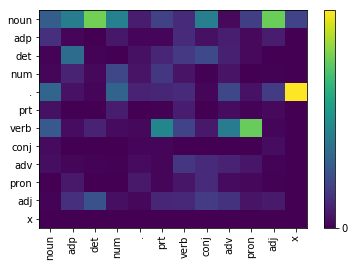

In [26]:
%matplotlib inline

corpus = pcc.PostagCorpus()
train_seq = corpus.read_sequence_list_conll(base_path+"/data/train-02-21.conll", max_sent_len=15, max_nr_sent=1000)
test_seq = corpus.read_sequence_list_conll(base_path+"/data/test-23.conll", max_sent_len=15, max_nr_sent=1000)
dev_seq = corpus.read_sequence_list_conll(base_path+"/data/dev-22.conll", max_sent_len=15, max_nr_sent=1000)
hmm = hmmc.HMM(corpus.word_dict, corpus.tag_dict)
hmm.train_supervised(train_seq)
hmm.print_transition_matrix()

In [27]:
viterbi_pred_train = hmm.viterbi_decode_corpus(train_seq)
posterior_pred_train = hmm.posterior_decode_corpus(train_seq)
eval_viterbi_train = hmm.evaluate_corpus(train_seq, viterbi_pred_train)
eval_posterior_train = hmm.evaluate_corpus(train_seq, posterior_pred_train)
print("Train Set Accuracy: Posterior Decode %.3f, Viterbi Decode: %.3f"%(
eval_posterior_train,eval_viterbi_train))

/home/pedro/Sandbox/lxmls-toolkit/lxmls/sequences/hmm.py:192: RuntimeWarning: divide by zero encountered in log
  emission_scores[pos, :] = np.log(self.emission_probs[sequence.x[pos], :])
/home/pedro/Sandbox/lxmls-toolkit/lxmls/sequences/hmm.py:194: RuntimeWarning: divide by zero encountered in log
  transition_scores[pos-1, :, :] = np.log(self.transition_probs)
/home/pedro/Sandbox/lxmls-toolkit/lxmls/sequences/hmm.py:197: RuntimeWarning: divide by zero encountered in log
  final_scores = np.log(self.final_probs)


Train Set Accuracy: Posterior Decode 0.985, Viterbi Decode: 0.985


In [28]:
viterbi_pred_test = hmm.viterbi_decode_corpus(test_seq)
posterior_pred_test = hmm.posterior_decode_corpus(test_seq)
eval_viterbi_test = hmm.evaluate_corpus(test_seq, viterbi_pred_test)
eval_posterior_test = hmm.evaluate_corpus(test_seq, posterior_pred_test)
print("Test Set Accuracy: Posterior Decode %.3f, Viterbi Decode: %.3f" % (eval_posterior_test, eval_viterbi_test))

/home/pedro/Sandbox/lxmls-toolkit/lxmls/sequences/hmm.py:192: RuntimeWarning: divide by zero encountered in log
  emission_scores[pos, :] = np.log(self.emission_probs[sequence.x[pos], :])
/home/pedro/Sandbox/lxmls-toolkit/lxmls/sequences/hmm.py:194: RuntimeWarning: divide by zero encountered in log
  transition_scores[pos-1, :, :] = np.log(self.transition_probs)
/home/pedro/Sandbox/lxmls-toolkit/lxmls/sequences/hmm.py:197: RuntimeWarning: divide by zero encountered in log
  final_scores = np.log(self.final_probs)
/home/pedro/Sandbox/lxmls-toolkit/lxmls/sequences/sequence_classifier.py:80: RuntimeWarning: invalid value encountered in subtract
  state_posteriors[pos, :] -= log_likelihood
/home/pedro/Sandbox/lxmls-toolkit/lxmls/sequences/sequence_classifier.py:93: RuntimeWarning: invalid value encountered in double_scalars
  transition_posteriors[pos, state, prev_state] -= log_likelihood


Test Set Accuracy: Posterior Decode 0.350, Viterbi Decode: 0.509


In [29]:
best_smothing = hmm.pick_best_smoothing(train_seq, dev_seq, [10, 1, 0.1, 0])

hmm.train_supervised(train_seq, smoothing=best_smothing)
viterbi_pred_test = hmm.viterbi_decode_corpus(test_seq)
posterior_pred_test = hmm.posterior_decode_corpus(test_seq)
eval_viterbi_test = hmm.evaluate_corpus(test_seq, viterbi_pred_test)
eval_posterior_test = hmm.evaluate_corpus(test_seq, posterior_pred_test)
print("Best Smoothing %f --  Test Set Accuracy: Posterior Decode %.3f, Viterbi Decode: %.3f" % (best_smothing, eval_posterior_test, eval_viterbi_test))

Smoothing 10.000000 --  Train Set Accuracy: Posterior Decode 0.731, Viterbi Decode: 0.691
Smoothing 10.000000 -- Test Set Accuracy: Posterior Decode 0.712, Viterbi Decode: 0.675
Smoothing 1.000000 --  Train Set Accuracy: Posterior Decode 0.887, Viterbi Decode: 0.865
Smoothing 1.000000 -- Test Set Accuracy: Posterior Decode 0.818, Viterbi Decode: 0.792
Smoothing 0.100000 --  Train Set Accuracy: Posterior Decode 0.968, Viterbi Decode: 0.965
Smoothing 0.100000 -- Test Set Accuracy: Posterior Decode 0.851, Viterbi Decode: 0.842


/home/pedro/Sandbox/lxmls-toolkit/lxmls/sequences/hmm.py:192: RuntimeWarning: divide by zero encountered in log
  emission_scores[pos, :] = np.log(self.emission_probs[sequence.x[pos], :])
/home/pedro/Sandbox/lxmls-toolkit/lxmls/sequences/hmm.py:194: RuntimeWarning: divide by zero encountered in log
  transition_scores[pos-1, :, :] = np.log(self.transition_probs)
/home/pedro/Sandbox/lxmls-toolkit/lxmls/sequences/hmm.py:197: RuntimeWarning: divide by zero encountered in log
  final_scores = np.log(self.final_probs)


Smoothing 0.000000 --  Train Set Accuracy: Posterior Decode 0.985, Viterbi Decode: 0.985


/home/pedro/Sandbox/lxmls-toolkit/lxmls/sequences/sequence_classifier.py:80: RuntimeWarning: invalid value encountered in subtract
  state_posteriors[pos, :] -= log_likelihood
/home/pedro/Sandbox/lxmls-toolkit/lxmls/sequences/sequence_classifier.py:93: RuntimeWarning: invalid value encountered in double_scalars
  transition_posteriors[pos, state, prev_state] -= log_likelihood


Smoothing 0.000000 -- Test Set Accuracy: Posterior Decode 0.370, Viterbi Decode: 0.526
Best Smoothing 0.100000 --  Test Set Accuracy: Posterior Decode 0.837, Viterbi Decode: 0.827


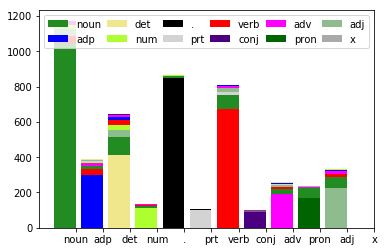

In [30]:
confusion_matrix = cm.build_confusion_matrix(test_seq.seq_list, viterbi_pred_test,
                                             len(corpus.tag_dict), hmm.get_num_states())

cm.plot_confusion_bar_graph(confusion_matrix, corpus.tag_dict,
                            range(hmm.get_num_states()), 'Confusion matrix')


# Excercice 2.10
Implement the method to update the counts given the state and transition posteriors

```
def update_counts(self, sequence, state_posteriors, transition_posteriors):
```

Look at the code for EM algorithm in file ```sequences/hmm.py``` and check it for yourself.

### Solution
````
def train_EM(self, dataset, smoothing=0, num_epochs=10, evaluate=True):
    self.initialize_random()

    if evaluate:
        acc = self.evaluate_EM(dataset)
        print "Initial accuracy: %f"%(acc)

    for t in xrange(1, num_epochs):
        #E-Step
        total_log_likelihood = 0.0
        self.clear_counts(smoothing)
        for sequence in dataset.seq_list:
            # Compute scores given the observation sequence.
            initial_scores, transition_scores, final_scores, emission_scores = \
                self.compute_scores(sequence)

            state_posteriors, transition_posteriors, log_likelihood = \
                self.compute_posteriors(initial_scores,
                                        transition_scores,
                                        final_scores,
                                        emission_scores)
            self.update_counts(sequence, state_posteriors, transition_posteriors)
            total_log_likelihood += log_likelihood

        print "Iter: %i Log Likelihood: %f"%(t, total_log_likelihood)
        #M-Step
        self.compute_parameters()
        if evaluate:
             ### Evaluate accuracy at this iteration
            acc = self.evaluate_EM(dataset)
            print "Iter: %i Accuracy: %f"%(t,acc)        
````

# Exercise 2.11
Implement the method to update the counts given the state and transition posteriors.

In [31]:
# Train with EM.
hmm.train_EM(train_seq, 0.1, 20, evaluate=True)
viterbi_pred_test = hmm.viterbi_decode_corpus(test_seq)
posterior_pred_test = hmm.posterior_decode_corpus(test_seq)
eval_viterbi_test = hmm.evaluate_corpus(test_seq, viterbi_pred_test)
eval_posterior_test = hmm.evaluate_corpus(test_seq, posterior_pred_test)

Initial accuracy: 0.319972
Iter: 1 Log Likelihood: -101635.181091
Iter: 1 Accuracy: 0.350336
Iter: 2 Log Likelihood: -78093.152879
Iter: 2 Accuracy: 0.374486
Iter: 3 Log Likelihood: -77949.523352
Iter: 3 Accuracy: 0.382804
Iter: 4 Log Likelihood: -77565.774816
Iter: 4 Accuracy: 0.386011
Iter: 5 Log Likelihood: -76692.621717
Iter: 5 Accuracy: 0.396332
Iter: 6 Log Likelihood: -75271.206440
Iter: 6 Accuracy: 0.408157
Iter: 7 Log Likelihood: -73743.000186
Iter: 7 Accuracy: 0.400040
Iter: 8 Log Likelihood: -72465.393159
Iter: 8 Accuracy: 0.396032
Iter: 9 Log Likelihood: -71404.924707
Iter: 9 Accuracy: 0.386011
Iter: 10 Log Likelihood: -70309.011482
Iter: 10 Accuracy: 0.385810
Iter: 11 Log Likelihood: -69157.358082
Iter: 11 Accuracy: 0.385810
Iter: 12 Log Likelihood: -68066.132335
Iter: 12 Accuracy: 0.385610
Iter: 13 Log Likelihood: -67145.335103
Iter: 13 Accuracy: 0.385510
Iter: 14 Log Likelihood: -66494.215591
Iter: 14 Accuracy: 0.385510
Iter: 15 Log Likelihood: -66120.737981
Iter: 15 Accu

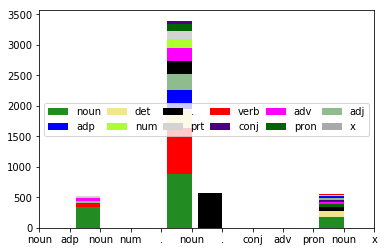

In [32]:
confusion_matrix = cm.build_confusion_matrix(test_seq.seq_list, viterbi_pred_test,
                                             len(corpus.tag_dict), hmm.get_num_states())
cm.plot_confusion_bar_graph(confusion_matrix, corpus.tag_dict,
                            range(hmm.get_num_states()), 'Confusion matrix')